# Portfolio Asset Clustering Project (Canary Group)

## Dataset Preparation and Feature Engineering

### Import Libraries and Initialize Variables

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import json
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy.stats.mstats import winsorize

# Clustering Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, MiniBatchKMeans, Birch   
from sklearn.mixture import GaussianMixture

# Metrics and Validation
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy import stats

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

### Apply Stratified Sampling to Select Tickers from Different Sectors (NYSE)

In [36]:
df_strata = pd.read_csv('companies.csv')
df_strata = df_strata.groupby('sector', group_keys=False).apply(lambda x: x.sample(frac=0.10))
tickers = df_strata['ticker'].tolist()
print('Number of tickers: ', len(tickers))
#write list to file in json format
with open('sampled_tickers.json', 'w') as f:
    json.dump(tickers, f)

#write list to csv file in single column
df_tickers = pd.DataFrame(tickers, columns=['ticker'])
df_tickers.to_csv('sampled_tickers.csv', index=False)


Number of tickers:  245


### Load Data

In [37]:
# Load data for 2Y (2023-2025)
#df = pd.read_excel('sp500_stock_data.xlsx', sheet_name='Stock_Data')
df = pd.read_excel('egx100_stock_data.xlsx', sheet_name='Stock_Data')
#df = pd.read_excel('NY1720_stock_data.xlsx', sheet_name='Stock_Data')
#df = pd.read_excel('NY165_stock_data.xlsx', sheet_name='Stock_Data')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Ticker', 'Date'])

print(f"Unique stocks: {df['Ticker'].nunique()}")
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Trading days: {df['Date'].nunique()}")

Unique stocks: 98
Date range: 2023-12-03 to 2025-12-01
Trading days: 484


### Feature calculation functions

In [38]:
def calculate_advanced_features(group):
    """Calculate comprehensive features for clustering"""
    
    features = {}
    returns = group['Daily_Return'].dropna()
    prices = group['Close']
    
    if len(returns) < 126:  # At least 6 months
        return pd.Series(features)
    
    # === FEATURE 1-3: RETURNS (annualized) ===
    features['return_mean'] = returns.mean() * 252
    features['return_total'] = (prices.iloc[-1] / prices.iloc[0] - 1) if len(prices) > 0 else 0
    features['return_6m'] = (prices.iloc[-1] / prices.iloc[-min(126, len(prices))] - 1) if len(prices) >= 126 else 0
    
    # === FEATURE 4-6: VOLATILITY ===
    features['volatility'] = returns.std() * np.sqrt(252)
    features['downside_vol'] = returns[returns < 0].std() * np.sqrt(252) if (returns < 0).any() else 0
    vol_rolling = returns.rolling(20).std() * np.sqrt(252)
    features['vol_stability'] = vol_rolling.std() / vol_rolling.mean() if vol_rolling.mean() > 0 else 0
    
    # === FEATURE 7-8: RISK-ADJUSTED ===
    features['sharpe'] = features['return_mean'] / features['volatility'] if features['volatility'] > 0 else 0
    features['sortino'] = features['return_mean'] / features['downside_vol'] if features['downside_vol'] > 0 else 0
    
    # === FEATURE 9: TAIL RISK ===
    features['var_95'] = abs(returns.quantile(0.05))
    
    # === FEATURE 10: DISTRIBUTION ===
    features['skewness'] = returns.skew()
    
    # === FEATURE 11-12: LIQUIDITY ===
    if 'Volume' in group.columns:
        volume = group['Volume']
        features['avg_volume'] = np.log1p(volume.mean())  # Log transform
        features['volume_stability'] = volume.std() / volume.mean() if volume.mean() > 0 else 0

    # === FEATURE 13-14: Technical Indicators ===
    features['rsi'] = 100 - (100 / (1 + (returns[returns > 0].mean() / abs(returns[returns < 0].mean())))) if abs(returns[returns < 0].mean()) > 0 else 100
    features['macd'] = prices.ewm(span=12, adjust=False).mean().iloc[-1] - prices.ewm(span=26, adjust=False).mean().iloc[-1]

    return pd.Series(features)

# Calculate features for each stock
stock_features = df.groupby('Ticker').apply(calculate_advanced_features)

# If the result is a Series with a MultiIndex (Ticker, Feature), unstack it to get a DataFrame.
if isinstance(stock_features, pd.Series) or isinstance(stock_features.index, pd.MultiIndex):
    stock_features = stock_features.unstack()

if 'company' in df.columns:
    companies = df.groupby('Ticker')['company'].first()
    stock_features = stock_features.join(companies)

if 'sector' in df.columns:
    sectors = df.groupby('Ticker')['sector'].first()
    stock_features = stock_features.join(sectors)

if 'industry' in df.columns:
    industries = df.groupby('Ticker')['industry'].first()
    stock_features = stock_features.join(industries)

print(f"\nFeatures calculated for {len(stock_features)} stocks")
print(f"Total features: {stock_features.select_dtypes(include=[np.number]).shape[1]}")

stock_features.to_excel('01_stocks_latest_features.xlsx', index=True)
stock_features.to_csv('01_stocks_latest_features.csv', index=True)


Features calculated for 98 stocks
Total features: 14


In [39]:
print(f"\n{'='*60}")
print("SUMMARY STATISTICS")
print(f"{'='*60}")

# Show feature summary
print("\nFeatures by category:")
print(f"  Returns: {len([c for c in stock_features.columns if 'return' in c.lower()])}")
print(f"  Risk: {len([c for c in stock_features.columns if 'var' in c.lower() or 'vol' in c.lower() or 'drawdown' in c.lower() or 'sharpe' in c.lower()])}")
print(f"  Technical: {len([c for c in stock_features.columns if any(x in c.lower() for x in ['sma', 'ema', 'rsi', 'macd'])])}")
print(f"  Statistical: {len([c for c in stock_features.columns if any(x in c.lower() for x in ['skew', 'kurt', 'autocorr'])])}")
print(f"  Liquidity: {len([c for c in stock_features.columns if 'volume' in c.lower() or 'liquidity' in c.lower()])}")
print(f"  Tail Risk: {len([c for c in stock_features.columns if any(x in c.lower() for x in ['tail', 'shortfall', 'gain_to_pain', 'win_rate'])])}")


SUMMARY STATISTICS

Features by category:
  Returns: 3
  Risk: 7
  Technical: 2
  Statistical: 1
  Liquidity: 2
  Tail Risk: 0


### LOAD AND EXPLORE DATA

In [40]:
stock_features = pd.read_excel('01_stocks_latest_features.xlsx', index_col=0)
print(f"\nDataset Shape: {stock_features.shape}")

# Separate numerical and categorical features
numerical_features = stock_features.select_dtypes(include=[np.number])
categorical_features = stock_features.select_dtypes(exclude=[np.number])

print(f"\nNumerical features: {len(numerical_features.columns)}")
print(f"Categorical features: {len(categorical_features.columns)}")

# Check for missing values
missing_vals = stock_features.isnull().sum()
missing_per = ((stock_features.isnull().sum() / len(stock_features)) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing_vals,'Percentage (%)': missing_per}) # Combine into a DataFrame for better visualization
missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)


Dataset Shape: (98, 15)

Numerical features: 14
Categorical features: 1


,Missing Count,Percentage (%)


## Feature Engineering and Dimensionality Reduction

### Feature Preprocessing and Scaling

In [41]:
print(f"\n{'='*80}")
print("PREPROCESSING PIPELINE")
print(f"{'='*80}\n")

features_processed = numerical_features.copy()
preprocessing_stats = {'original_features': features_processed.shape[1]}

# STEP 1: Handle Missing Values with KNN Imputer
missing_count = features_processed.isnull().sum().sum()
if missing_count > 0:
    print(f"[1] Imputing {missing_count} missing values using KNN (k=5)...")
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    features_processed = pd.DataFrame(
        imputer.fit_transform(features_processed),
        index=features_processed.index,
        columns=features_processed.columns
    )
else:
    print("[1] No missing values found")

# STEP 2: Handle Infinite Values
inf_count = np.isinf(features_processed).sum().sum()
if inf_count > 0:
    print(f"[2] Handling {inf_count} infinite values...")
    features_processed = features_processed.replace([np.inf, -np.inf], np.nan)
    features_processed = features_processed.fillna(features_processed.median())
else:
    print("[2] No infinite values found")

# # STEP 3: Remove near zero-variance features
# print("[3] Removing near zero-variance features...")
# feature_vars = features_processed.var()
# low_var = feature_vars[feature_vars < 0.001].index
# if len(low_var) > 0:
#     print(f'Removing {len(low_var)} near zero-variance features: {list(low_var)}')
#     features_processed = features_processed.drop(columns=low_var)
# preprocessing_stats['low_variance_removed'] = len(low_var)

# STEP 4: Winsorize Outliers
print("\n[2] Clipping outliers (Winsorization 2.5%)...")
outliers_clipped = 0
for col in features_processed.columns:
    q025 = features_processed[col].quantile(0.025)
    q975 = features_processed[col].quantile(0.975)
    before = ((features_processed[col] < q025) | (features_processed[col] > q975)).sum()
    features_processed[col] = winsorize(features_processed[col], limits=[0.025, 0.025])
    outliers_clipped += before
print(f"    → Clipped {outliers_clipped} outlier values")

# STEP 5: Log Transform Skewed Features
# Volatility and Volume are often log-normal. Transforming them helps KMeans.
print("\n[3] Log-transforming skewed features...")
skewed_cols = ['avg_volume', 'volatility', 'downside_vol', 'var_95', 'rsi']
transformed = []
for col in skewed_cols:
    if col in features_processed.columns:
        # Ensure positive before log
        if (features_processed[col] <= 0).any():
            features_processed[col] = np.log1p(features_processed[col] - features_processed[col].min() + 1e-6)
        else:
            features_processed[col] = np.log1p(features_processed[col])
        transformed.append(col)
# print(f"    → Transformed: {transformed}")
# Volatility and Volume squared-transform
# transformed = []
# for col in skewed_cols:
#     if col in features_processed.columns:
#         features_processed[col] = np.sign(features_processed[col]) * np.sqrt(np.abs(features_processed[col]))
#         transformed.append(col)
# print(f"    → Transformed: {transformed}")
    
# STEP 6: Feature Selection: Remove Highly Correlated Features
# High correlation adds weight to a specific dimension without adding info.
print("\n[4] Removing highly correlated features (>0.85)...")
corr_matrix = features_processed.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

if to_drop:
    print(f"    → Dropping: {to_drop}")
    df_selected = features_processed.drop(columns=to_drop)
else:
    print(f"    → No highly correlated features found")
    df_selected = features_processed

# STEP 7: Scaling RobustScaler is better than StandardScaler for financial data (less sensitive to outliers)
print("\n[5] Scaling features (RobustScaler)...")
scaler = RobustScaler()
features_scaled = scaler.fit_transform(df_selected)
features_scaled = pd.DataFrame(features_scaled, columns=df_selected.columns, index=df_selected.index)

print(f"\n{'='*80}")
print("PREPROCESSING SUMMARY")
print(f"{'='*80}")
print(f"Original features:        {preprocessing_stats['original_features']}")
# print(f"Low-variance removed:     {preprocessing_stats['low_variance_removed']}")
print(f"Outliers winsorized:      {outliers_clipped}")
print(f"Final features:           {len(features_scaled.columns)}")
print(f"Stocks in analysis:       {len(features_scaled)}")

features_scaled.to_csv('02_features_preprocessed.csv')


PREPROCESSING PIPELINE

[1] No missing values found
[2] No infinite values found

[2] Clipping outliers (Winsorization 2.5%)...
    → Clipped 84 outlier values

[3] Log-transforming skewed features...

[4] Removing highly correlated features (>0.85)...
    → Dropping: ['return_total', 'sharpe', 'sortino']

[5] Scaling features (RobustScaler)...

PREPROCESSING SUMMARY
Original features:        14
Outliers winsorized:      84
Final features:           11
Stocks in analysis:       98


### Keep only Descriminative features after Preprocessing

In [42]:
# Use preliminary clustering to identify discriminative features
preliminary_kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
preliminary_labels = preliminary_kmeans.fit_predict(features_scaled)

# Calculate feature importance based on cluster separation
feature_importance = {}
for col in features_scaled.columns:
    # Calculate variance between clusters vs within clusters
    between_var = 0
    within_var = 0
    overall_mean = features_scaled[col].mean()
    
    for cluster in range(3):
        cluster_data = features_scaled[preliminary_labels == cluster][col]
        cluster_mean = cluster_data.mean()
        cluster_size = len(cluster_data)
        
        between_var += cluster_size * (cluster_mean - overall_mean)**2
        within_var += ((cluster_data - cluster_mean)**2).sum()
    
    # F-statistic
    f_stat = (between_var / 2) / (within_var / (len(features_scaled) - 3)) if within_var > 0 else 0
    feature_importance[col] = f_stat

# Rank features
importance_df = pd.DataFrame({
    'Feature': feature_importance.keys(),
    'Importance': feature_importance.values()
}).sort_values('Importance', ascending=False)

print('\nFeature Importance Ranking:')
for idx, row in importance_df.iterrows():
    print(f"  {row['Feature']:20s}: {row['Importance']:.3f}")

# Keep top 8-10 features
n_features_to_keep = min(10, len(importance_df))
top_features = importance_df.head(n_features_to_keep)['Feature'].tolist()

features_selected = features_scaled[top_features]

print(f'\n✓ Selected top {len(top_features)} features:')
print(f'  {top_features}')
features_selected.to_csv('04_features_selected.csv')


Feature Importance Ranking:
  macd                : 166.200
  downside_vol        : 111.778
  vol_stability       : 35.554
  return_6m           : 21.262
  skewness            : 21.004
  volatility          : 18.348
  avg_volume          : 4.611
  var_95              : 2.410
  return_mean         : 2.170
  volume_stability    : 0.382
  rsi                 : 0.303

✓ Selected top 10 features:
  ['macd', 'downside_vol', 'vol_stability', 'return_6m', 'skewness', 'volatility', 'avg_volume', 'var_95', 'return_mean', 'volume_stability']


### PCA for Dimensionality Reduction

In [43]:
best_score = -1
best_k = 0
best_pca = 0
best_labels = None
best_pca_data = None

results_log = []

# Try different PCA components (2 to min(6, n_features))
n_features = features_scaled.shape[1]
pca_options = list(range(2, min(7, n_features) + 1))

for n_components in pca_options:
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(features_scaled)
    
    # Try different K (3 to 8)
    # Avoid K=2 as it often just splits market vs non-market
    for k in range(3, 9):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=500)
        labels = kmeans.fit_predict(X_pca)
        
        # Calculate metrics
        inertia_score = kmeans.inertia_
        sil_score = silhouette_score(X_pca, labels)
        cal_score = calinski_harabasz_score(X_pca, labels)
        db_score = davies_bouldin_score(X_pca, labels)
        
        # Balance score
        sizes = pd.Series(labels).value_counts().values
        balance = sizes.min() / sizes.max()
        
        results_log.append({
            'pca': n_components,
            'k': k,
            'inertia': inertia_score,
            'silhouette': sil_score,
            'calinski': cal_score,
            'davies_bouldin': db_score,
            'balance': balance
        })
        
        # Update best by prioritizing silhouette but also consider balance
        if sil_score > best_score:
            best_score = sil_score
            best_k = k
            best_pca = n_components
            best_labels = labels
            best_pca_data = X_pca
            best_pca_model = pca

results_df = pd.DataFrame(results_log).sort_values('silhouette', ascending=False)
print("\nTop 10 Combinations:")
print("="*90)
print(f"{'PCA':<5} {'K':<4} {'Silhouette':<12} {'Balance':<10} {'Calinski-H':<12} {'Davies-B':<12}")
print("="*90)
for i, row in results_df.head(10).iterrows():
    marker = " ← SELECTED" if (row['pca'] == best_pca and row['k'] == best_k) else ""
    print(f"{row['pca']:<5.0f} {row['k']:<4.0f} {row['silhouette']:<12.4f} {row['balance']:<10.3f} "
            f"{row['calinski']:<12.2f} {row['davies_bouldin']:<12.4f}{marker}")

print(f"\n🏆 BEST RESULT FOUND:")
print(f"Silhouette Score: {best_score:.4f}")
print(f"Number of Clusters (k): {best_k}")
print(f"PCA Components: {best_pca}")
print(f"Variance Explained: {best_pca_model.explained_variance_ratio_.sum()*100:.2f}%")


final_df = features_processed.loc[features_processed.index].copy()
final_df['Cluster'] = best_labels

print("\nCluster Sizes:")
print(final_df['Cluster'].value_counts().sort_index())

# Save
final_df.to_csv('03_features_pca.csv')


Top 10 Combinations:
PCA   K    Silhouette   Balance    Calinski-H   Davies-B    
2     3    0.6346       0.071      151.11       0.5622       ← SELECTED
3     3    0.5727       0.071      100.41       0.8017      
2     6    0.5594       0.043      172.58       0.5513      
2     5    0.5581       0.086      168.21       0.5828      
4     3    0.5352       0.071      87.33        0.8451      
5     3    0.5216       0.071      80.53        0.8865      
6     3    0.5106       0.071      76.86        0.9026      
7     3    0.5038       0.071      74.64        0.9189      
2     4    0.4912       0.085      154.71       0.6775      
3     6    0.3857       0.054      91.55        0.8016      

🏆 BEST RESULT FOUND:
Silhouette Score: 0.6346
Number of Clusters (k): 3
PCA Components: 2
Variance Explained: 78.61%

Cluster Sizes:
Cluster
0    84
1     6
2     8
Name: count, dtype: int64


### Visualize Scoring Metrics for different PCA and K values

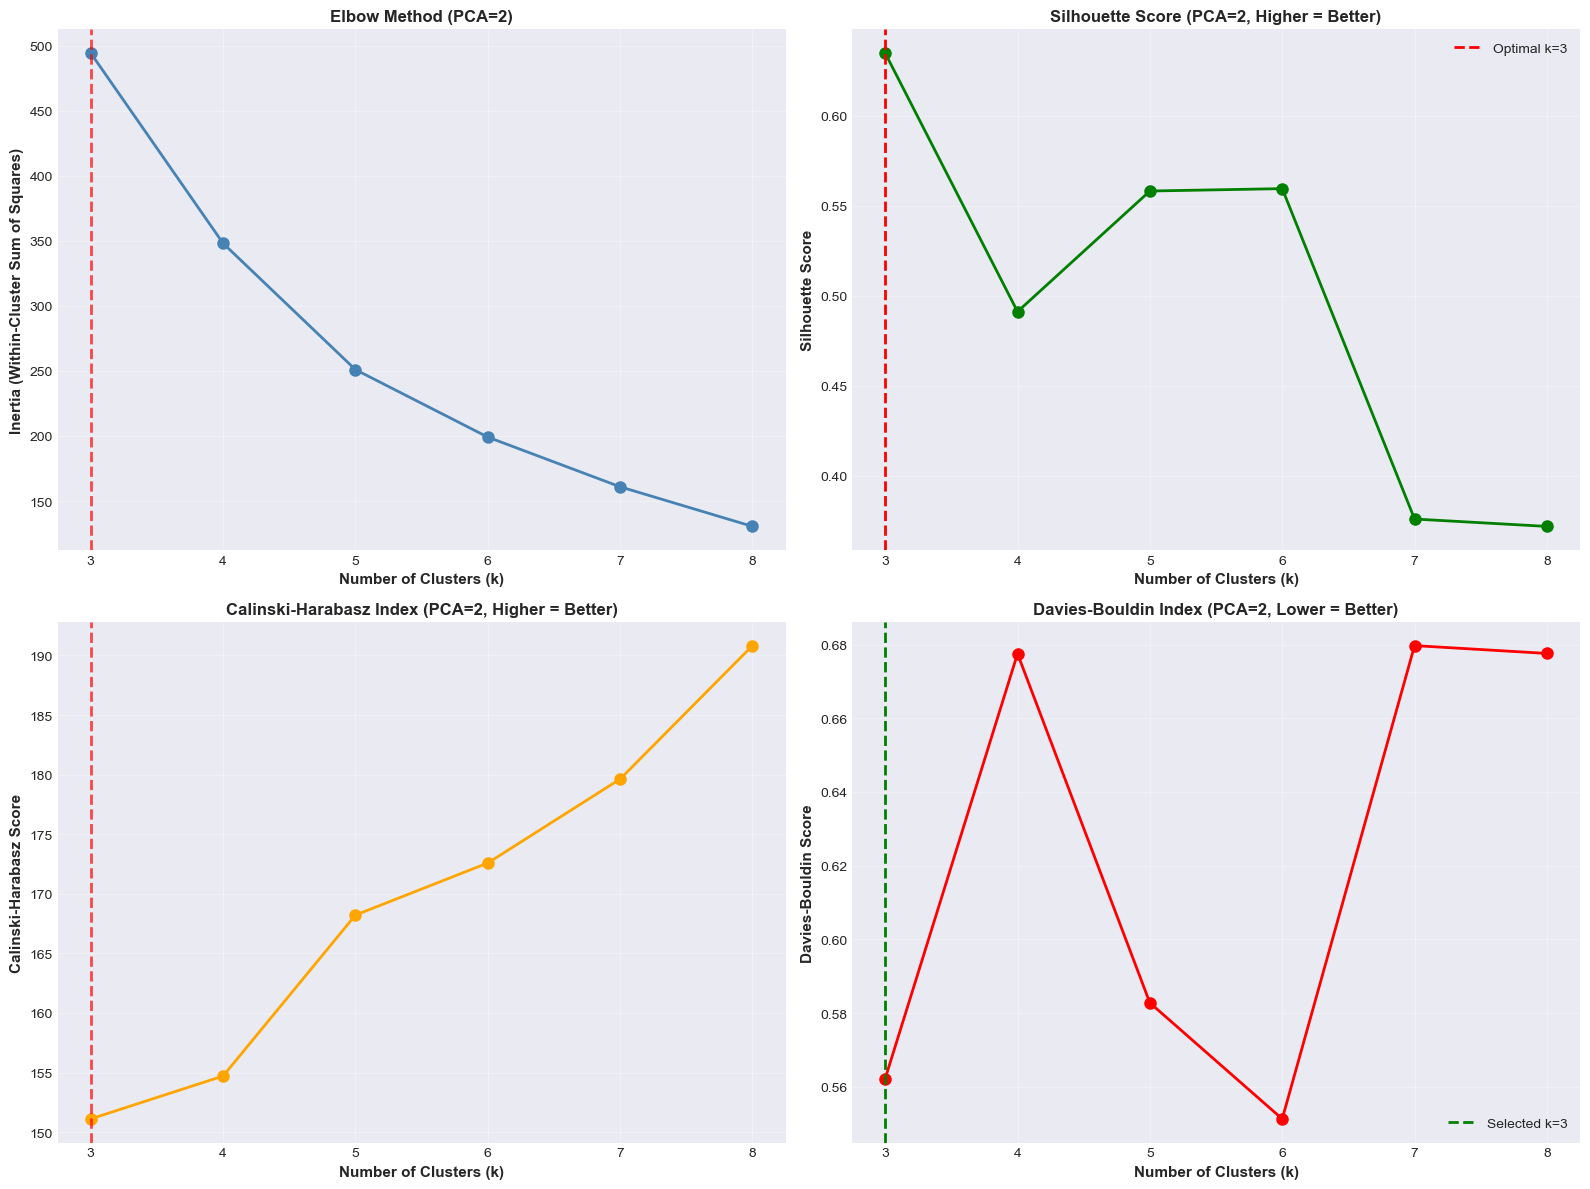


All metrics for PCA=2 components across k=3 to 8 clusters


In [44]:
# Prepare data for visualization - filter by best PCA components
best_pca_results = results_df[results_df['pca'] == best_pca].sort_values('k')

k_values = best_pca_results['k'].values
inertia_values = best_pca_results['inertia'].values
silhouette_values = best_pca_results['silhouette'].values
calinski_values = best_pca_results['calinski'].values
davies_bouldin_values = best_pca_results['davies_bouldin'].values

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Elbow plot
axes[0, 0].plot(k_values, inertia_values, 'o-', linewidth=2, markersize=8, color='steelblue')
axes[0, 0].axvline(x=best_k, color='r', linestyle='--', linewidth=2, alpha=0.7)
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=11, fontweight='bold')
axes[0, 0].set_title(f'Elbow Method (PCA={best_pca})', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(k_values)

# Silhouette scores
axes[0, 1].plot(k_values, silhouette_values, 'o-', linewidth=2, markersize=8, color='green')
axes[0, 1].axvline(x=best_k, color='r', linestyle='--', linewidth=2, label=f'Optimal k={best_k}')
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
axes[0, 1].set_title(f'Silhouette Score (PCA={best_pca}, Higher = Better)', fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='best', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(k_values)

# Calinski-Harabasz
axes[1, 0].plot(k_values, calinski_values, 'o-', linewidth=2, markersize=8, color='orange')
axes[1, 0].axvline(x=best_k, color='r', linestyle='--', linewidth=2, alpha=0.7)
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=11, fontweight='bold')
axes[1, 0].set_title(f'Calinski-Harabasz Index (PCA={best_pca}, Higher = Better)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(k_values)

# Davies-Bouldin
axes[1, 1].plot(k_values, davies_bouldin_values, 'o-', linewidth=2, markersize=8, color='red')
axes[1, 1].axvline(x=best_k, color='g', linestyle='--', linewidth=2, label=f'Selected k={best_k}')
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Davies-Bouldin Score', fontsize=11, fontweight='bold')
axes[1, 1].set_title(f'Davies-Bouldin Index (PCA={best_pca}, Lower = Better)', fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='best', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(k_values)

plt.tight_layout()
plt.savefig('05_optimal_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAll metrics for PCA={best_pca} components across k={k_values.min()} to {k_values.max()} clusters")

### Optimal Number of Clusters

In [45]:
clustering_results = {}

#features_scaled = pd.read_csv('02_features_preprocessed.csv').drop(columns=['Ticker'])
#features_scaled = pd.read_csv('03_features_pca.csv').drop(columns=['Ticker'])
#features_scaled = pd.read_csv('04_features_selected.csv').drop(columns=['Ticker'])
#features_scaled = numerical_features
#features_scaled = X_processed

# Use PCA data for fair comparison
features_scaled = best_pca_data

# Define algorithms to test
algorithms = {
    'K-Means': KMeans(n_clusters=best_k, random_state=42, n_init=20),
    'Mini-Batch K-Means': MiniBatchKMeans(n_clusters=best_k, random_state=42, n_init=20),
    'Hierarchical (Ward)': AgglomerativeClustering(n_clusters=best_k, linkage='ward'),
    'Hierarchical (Average)': AgglomerativeClustering(n_clusters=best_k, linkage='average'),
    'Gaussian Mixture': GaussianMixture(n_components=best_k, random_state=42, n_init=10),
    'Spectral': SpectralClustering(n_clusters=best_k, random_state=42, affinity='nearest_neighbors'),
    'DBSCAN': DBSCAN(eps=2.5,min_samples=3)
}

for name, model in algorithms.items():
    try:
        labels = model.fit_predict(features_scaled)
        
        sil_score = silhouette_score(features_scaled, labels)
        cal_score = calinski_harabasz_score(features_scaled, labels)
        db_score = davies_bouldin_score(features_scaled, labels)
        
        sizes = pd.Series(labels).value_counts().values
        balance = sizes.min() / sizes.max()
        
        clustering_results[name] = {
            'labels': labels,
            'silhouette': sil_score,
            'calinski': cal_score,
            'davies_bouldin': db_score,
            'balance': balance
        }
        
    except Exception as e:
        print(f"⚠ {name} failed: {str(e)[:60]}")
        continue

# Create comparison table
comparison_df = pd.DataFrame({
    'Algorithm': list(clustering_results.keys()),
    'Silhouette': [v['silhouette'] for v in clustering_results.values()],
    'Balance': [v['balance'] for v in clustering_results.values()],
    'Calinski-H': [v['calinski'] for v in clustering_results.values()],
    'Davies-B': [v['davies_bouldin'] for v in clustering_results.values()]
}).sort_values('Silhouette', ascending=False)

print("\nALGORITHM COMPARISON RESULTS")
print("="*100)
print(f"{'Algorithm':<25} {'Silhouette':<15} {'Balance':<12} {'Calinski-H':<15} {'Davies-B':<12}")
print("="*100)

for idx, row in comparison_df.iterrows():
    marker = " ← BEST" if idx == comparison_df.index[0] else ""
    print(f"{row['Algorithm']:<25} {row['Silhouette']:<15.4f} {row['Balance']:<12.3f} "
            f"{row['Calinski-H']:<15.2f} {row['Davies-B']:<12.4f}{marker}")

best_algorithm = comparison_df.iloc[0]['Algorithm']
best_sil = comparison_df.iloc[0]['Silhouette']
best_labels = clustering_results[best_algorithm]['labels']

print(f"\nBest Algorithm: {best_algorithm}")
print(f"Silhouette Score: {best_sil:.4f}")

numerical_features['Cluster_Best_Algorithm'] = best_labels

# Cluster distribution
cluster_counts = pd.Series(best_labels).value_counts().sort_index()
print(f"\nCluster Distribution:")
for cluster, count in cluster_counts.items():
    cluster_label = f"Noise" if cluster == -1 else f"Cluster {cluster}"
    print(f"  {cluster_label}: {count:3d} stocks ({count/len(best_labels)*100:5.1f}%)")


ALGORITHM COMPARISON RESULTS
Algorithm                 Silhouette      Balance      Calinski-H      Davies-B    
Hierarchical (Average)    0.7209          0.022        121.57          0.2763       ← BEST
DBSCAN                    0.6762          0.045        64.51           1.3688      
K-Means                   0.6346          0.071        151.11          0.5622      
Hierarchical (Ward)       0.6346          0.071        151.11          0.5622      
Mini-Batch K-Means        0.6346          0.071        151.11          0.5622      
Gaussian Mixture          0.6346          0.071        151.11          0.5622      
Spectral                  0.0747          0.333        40.65           1.0803      

Best Algorithm: Hierarchical (Average)
Silhouette Score: 0.7209

Cluster Distribution:
  Cluster 0:  90 stocks ( 91.8%)
  Cluster 1:   6 stocks (  6.1%)
  Cluster 2:   2 stocks (  2.0%)


### Compare Clustering Algorithms

In [46]:
print("\n" + "=" * 80)
print("CLUSTERING ALGORITHM COMPARISON")
print("=" * 80)

# Store results
clustering_results = {}

# 1. K-Means
print("\n[1] K-Means Clustering")
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels_kmeans = kmeans.fit_predict(features_scaled)
clustering_results['K-Means'] = {
    'labels': labels_kmeans,
    'silhouette': silhouette_score(features_scaled, labels_kmeans),
    'calinski': calinski_harabasz_score(features_scaled, labels_kmeans),
    'davies_bouldin': davies_bouldin_score(features_scaled, labels_kmeans),
    'balance': pd.Series(labels_kmeans).value_counts().min() / pd.Series(labels_kmeans).value_counts().max()
}
print(f"   Silhouette: {clustering_results['K-Means']['silhouette']:.4f}")
print(f"   Calinski-Harabasz: {clustering_results['K-Means']['calinski']:.2f}")
print(f"   Davies-Bouldin: {clustering_results['K-Means']['davies_bouldin']:.4f}")
print(f"   Balance: {clustering_results['K-Means']['balance']:.4f}")

# 2. Hierarchical (Ward)
print("\n[2] Hierarchical Clustering (Ward)")
hierarchical = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
labels_hierarchical = hierarchical.fit_predict(features_scaled)
clustering_results['Hierarchical'] = {
    'labels': labels_hierarchical,
    'silhouette': silhouette_score(features_scaled, labels_hierarchical),
    'calinski': calinski_harabasz_score(features_scaled, labels_hierarchical),
    'davies_bouldin': davies_bouldin_score(features_scaled, labels_hierarchical),
    'balance': pd.Series(labels_hierarchical).value_counts().min() / pd.Series(labels_hierarchical).value_counts().max()
}
print(f"   Silhouette: {clustering_results['Hierarchical']['silhouette']:.4f}")
print(f"   Calinski-Harabasz: {clustering_results['Hierarchical']['calinski']:.2f}")
print(f"   Davies-Bouldin: {clustering_results['Hierarchical']['davies_bouldin']:.4f}")
print(f"   Balance: {clustering_results['Hierarchical']['balance']:.4f}")

# # 3. DBSCAN Model
# print("\n[3] DBSCAN  Model")
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# labels_dbscan = dbscan.fit_predict(features_scaled)
# clustering_results['DBSCAN'] = {
#     'labels': labels_dbscan,
#     'silhouette': silhouette_score(features_scaled, labels_dbscan),
#     'calinski': calinski_harabasz_score(features_scaled, labels_dbscan),
#     'davies_bouldin': davies_bouldin_score(features_scaled, labels_dbscan),
#     'balance': pd.Series(labels_dbscan).value_counts().min() / pd.Series(labels_dbscan).value_counts().max()
# }
# print(f"   Silhouette: {clustering_results['DBSCAN']['silhouette']:.4f}")
# print(f"   Calinski-Harabasz: {clustering_results['DBSCAN']['calinski']:.2f}")
# print(f"   Davies-Bouldin: {clustering_results['DBSCAN']['davies_bouldin']:.4f}")

# Select best algorithm
best_algorithm = max(clustering_results.items(), key=lambda x: x[1]['silhouette'])[0]
best_labels = clustering_results[best_algorithm]['labels']

print("\n" + "=" * 80)
print("ALGORITHM COMPARISON SUMMARY")
print("=" * 80)
comparison_df = pd.DataFrame({
    'Algorithm': list(clustering_results.keys()),
    'Silhouette': [v['silhouette'] for v in clustering_results.values()],
    'Calinski-Harabasz': [v['calinski'] for v in clustering_results.values()],
    'Davies-Bouldin': [v['davies_bouldin'] for v in clustering_results.values()]
}).sort_values('Silhouette', ascending=False)
print(comparison_df.to_string(index=False))

print(f"\n✓ BEST ALGORITHM: {best_algorithm}")
print(f"   Silhouette Score: {clustering_results[best_algorithm]['silhouette']:.4f}")

# Add cluster labels to features
numerical_features['Cluster'] = best_labels

# Cluster distribution
print("\nCluster Distribution:")
cluster_counts = pd.Series(best_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = count / len(best_labels) * 100
    print(f"   Cluster {cluster}: {count} stocks ({pct:.1f}%)")


CLUSTERING ALGORITHM COMPARISON

[1] K-Means Clustering
   Silhouette: 0.6346
   Calinski-Harabasz: 151.11
   Davies-Bouldin: 0.5622
   Balance: 0.0714

[2] Hierarchical Clustering (Ward)
   Silhouette: 0.6346
   Calinski-Harabasz: 151.11
   Davies-Bouldin: 0.5622
   Balance: 0.0714

ALGORITHM COMPARISON SUMMARY
   Algorithm  Silhouette  Calinski-Harabasz  Davies-Bouldin
     K-Means    0.634646         151.108737        0.562241
Hierarchical    0.634646         151.108737        0.562241

✓ BEST ALGORITHM: K-Means
   Silhouette Score: 0.6346

Cluster Distribution:
   Cluster 0: 84 stocks (85.7%)
   Cluster 1: 6 stocks (6.1%)
   Cluster 2: 8 stocks (8.2%)


### Post Clustering Analysis

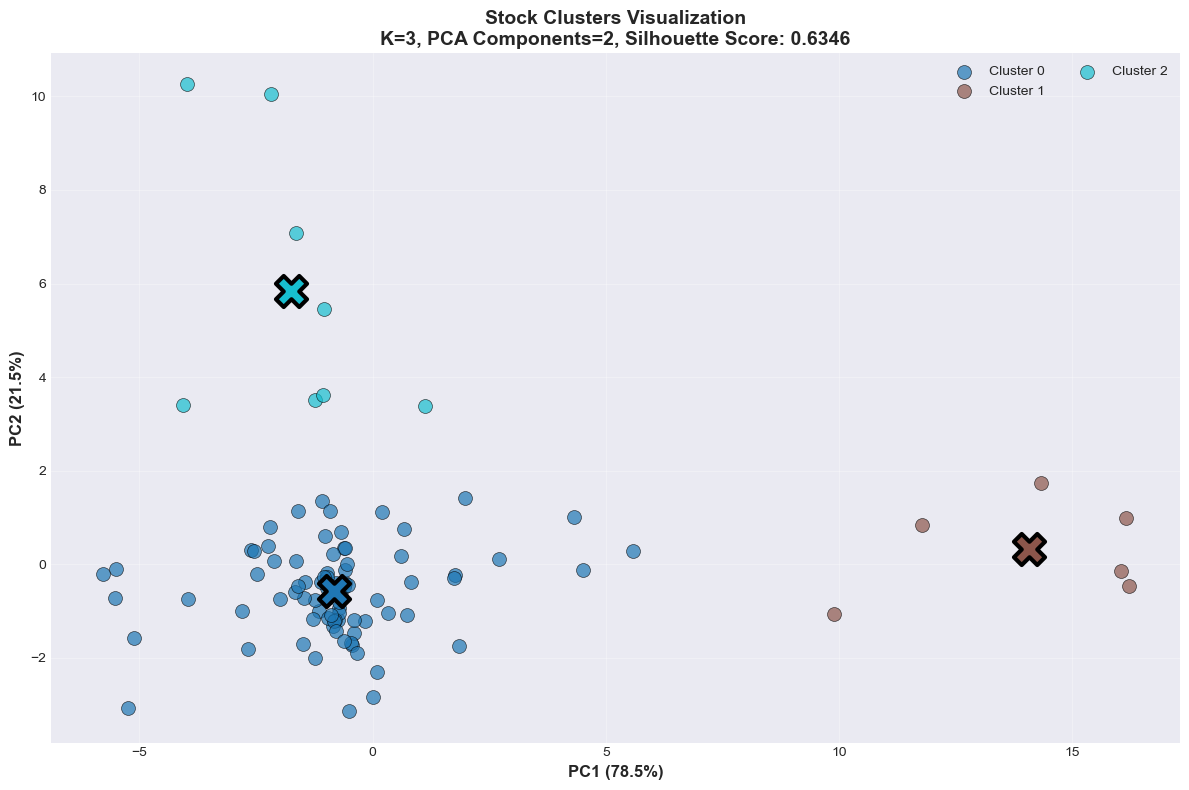

In [47]:
# Visualize clusters using the best PCA result (2D projection for visualization)
pca_viz = PCA(n_components=2, random_state=42)
features_pca_2d = pca_viz.fit_transform(features_scaled)

plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, best_k))

for cluster in range(best_k):
    mask = best_labels == cluster
    plt.scatter(features_pca_2d[mask, 0], features_pca_2d[mask, 1],
                c=[colors[cluster]], label=f'Cluster {cluster}',
                s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Centroid
    centroid = features_pca_2d[mask].mean(axis=0)
    plt.scatter(centroid[0], centroid[1], marker='X', s=500,
                c=[colors[cluster]], edgecolors='black', linewidth=3, zorder=10)

plt.xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12, fontweight='bold')
plt.title(f'Stock Clusters Visualization\nK={best_k}, PCA Components={best_pca}, Silhouette Score: {best_score:.4f}', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best', ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'06_cluster_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

### Cluster Analysis

In [48]:
for cluster in sorted(numerical_features['Cluster'].unique()):
    cluster_stocks = numerical_features[numerical_features['Cluster'] == cluster]
    
    print(f'\nCluster {cluster} ({len(cluster_stocks)} stocks, {len(cluster_stocks)/len(numerical_features)*100:.1f}%)')
    print('-'*70)
    
    numeric_cols = [col for col in cluster_stocks.columns if col != 'Cluster']
    
    if len(numeric_cols) > 0:
        cluster_means = cluster_stocks[numeric_cols].mean()
        overall_means = numerical_features[numeric_cols].mean()
        
        print('\nKey Characteristics (vs overall avg):')
        for col in numeric_cols[:8]:  # Show top 8
            val = cluster_means[col]
            overall = overall_means[col]
            diff = ((val / overall - 1) * 100) if overall != 0 else 0
            direction = '↑' if diff > 5 else '↓' if diff < -5 else '≈'
            print(f'  {col:20s}: {val:8.4f} {direction} {abs(diff):6.1f}%')



Cluster 0 (84 stocks, 85.7%)
----------------------------------------------------------------------

Key Characteristics (vs overall avg):
  return_mean         :   0.3936 ↓    7.5%
  return_total        :   0.9852 ≈    2.5%
  return_6m           :   0.1680 ↓   15.5%
  volatility          :   0.4775 ↓    7.5%
  downside_vol        :   0.2922 ↓    8.1%
  vol_stability       :   0.4748 ↓    9.2%
  sharpe              :   0.7690 ≈    3.1%
  sortino             :   1.3472 ≈    2.4%

Cluster 1 (6 stocks, 6.1%)
----------------------------------------------------------------------

Key Characteristics (vs overall avg):
  return_mean         :   0.6643 ↑   56.1%
  return_total        :   2.1295 ↑  110.8%
  return_6m           :   1.0612 ↑  434.1%
  volatility          :   0.4492 ↓   13.0%
  downside_vol        :   0.2619 ↓   17.7%
  vol_stability       :   0.4646 ↓   11.1%
  sharpe              :   1.4432 ↑   81.9%
  sortino             :   2.4890 ↑   80.3%

Cluster 2 (8 stocks, 8.2%)
------